In [1]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
import numpy as np

## Entangled State

In [2]:
qc = QuantumCircuit(2,2)

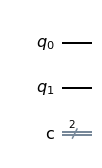

In [3]:
qc.draw(output='mpl')

In [4]:
qc.h(0)
qc.cx(0,1)
qc.measure([0,1],[0,1])

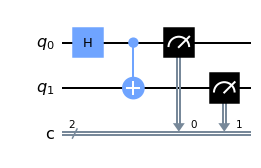

In [5]:
qc.draw(output='mpl')

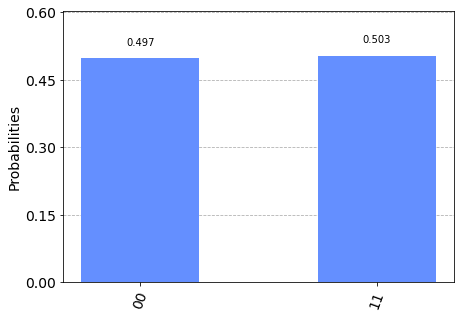

In [6]:
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

## BB84

In [215]:
N = 40
eve_intercept = True
detect_rate = 0.9 # interception_detection_percentage 

### Alice Encode Message

In [216]:
alice_bits = np.random.randint(2, size=N)
alice_basis = np.random.randint(2, size=N)

In [217]:
print(alice_bits)

[0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0
 0 0 0]


In [218]:
print(alice_basis)

[0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1
 1 0 0]


In [219]:
def encode_message(bits, basis, N):
    message = list()
    for i in range(N):
        qc = QuantumCircuit(1, 1)
        
        if basis[i] == 0:
            if bits[i] == 0:
                pass
            else:
                qc.x(0)
        else:
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

In [220]:
message = encode_message(alice_bits, alice_basis, N)

### Decode Message Func (for Eve and Bob)

In [221]:
def decode_message(message, basis, N):
    decoded_message = list()
    for i in range(N):
        if basis[i] == 0:
            message[i].measure(0, 0)
        else:
            message[i].h(0)
            message[i].measure(0,0)
        backend = Aer.get_backend('aer_simulator')
        qobj = assemble(message[i], shots=1, memory=True)
        result = backend.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        decoded_message.append(measured_bit)
    return decoded_message

### Eve Intercept

In [222]:
def do_interception():
    eve_basis = np.random.randint(2, size=N)
    eve_message = decode_message(message, eve_basis, N)
    print(eve_message)

In [223]:
if eve_intercept:
    do_interception()

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]


### Bob Decode Message

In [224]:
bob_basis = np.random.randint(2, size=N)
bob_bits = decode_message(message, bob_basis, N)

In [225]:
print(bob_bits)

[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]


In [226]:
print(alice_bits)

[0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0
 0 0 0]


In [227]:
print(bob_basis)

[1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0
 0 0 1]


In [228]:
print(alice_basis)

[0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1
 1 0 0]


### Check for Matching Basis

In [229]:
alice_valid_bits = list()
bob_valid_bits = list()
N2 = 0
for i in range(N):
    if (alice_basis[i] == bob_basis[i]):
        alice_valid_bits.append(alice_bits[i])
        bob_valid_bits.append(bob_bits[i])
        N2 += 1

In [230]:
print("N2 =", N2)

N2 = 21


In [231]:
print(alice_valid_bits)
print(bob_valid_bits)

[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
[0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0]


### Check for Interception

In [232]:
NUse = N2
escape_rate = 1
acceptable_escape_rate = 1-detect_rate
while NUse > 0 and escape_rate > acceptable_escape_rate:
    NUse -= 1
    escape_rate *= .75

In [233]:
is_intercepted = False
for i in range(NUse, N2):
    if alice_valid_bits[i] != bob_valid_bits[i]:
        is_intercepted = True

In [234]:
keys = list()
for i in range(NUse):
    keys.append(alice_valid_bits[i])

In [235]:
print("Keys =", alice_valid_bits)

Keys = [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]


In [236]:
print("Intercepted is", is_intercepted, "with confidence rate", 1-escape_rate)

Intercepted is True with confidence rate 0.9249153137207031
